# Notebook to visualise output from large training routines carried out on fields

In [2]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from plot import *
from utils import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams.update({'font.size': 18})

In [3]:
# useful to define the model structures we will be using here
 ### Define the different hLN architectures we will be using:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = np.array([0])
# 2N
Jc_2n = np.array([0, 1, 1])
# 3N
Jc_3n = np.array([0, 1, 1, 2, 2, 3, 3])
# 4N
Jc_4n = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

# list of lists for to define hierarchical clustering
clusts = [[[[[0, 1], [2]], [[3, 4], [5, 6]]], [[[7, 8], [9]], [[10, 11], [12]]]]]

Wce_1l, Wci_1l = create_weights(Jc_1l, n_levels=1, clusts=clusts)
Wce_2n, Wci_2n = create_weights(Jc_2n, n_levels=2, clusts=clusts)
Wce_3n, Wci_3n = create_weights(Jc_3n, n_levels=3, clusts=clusts)
Wce_4n, Wci_4n = create_weights(Jc_4n, n_levels=4, clusts=clusts)

In [5]:
loaded = np.load('/tmp/training_data.npz', allow_pickle=True)

In [6]:
train_accs, test_accs, trained_plist, target_plist = loaded['a'], loaded['b'], loaded['c'], loaded['d']

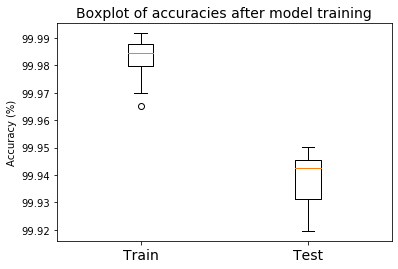

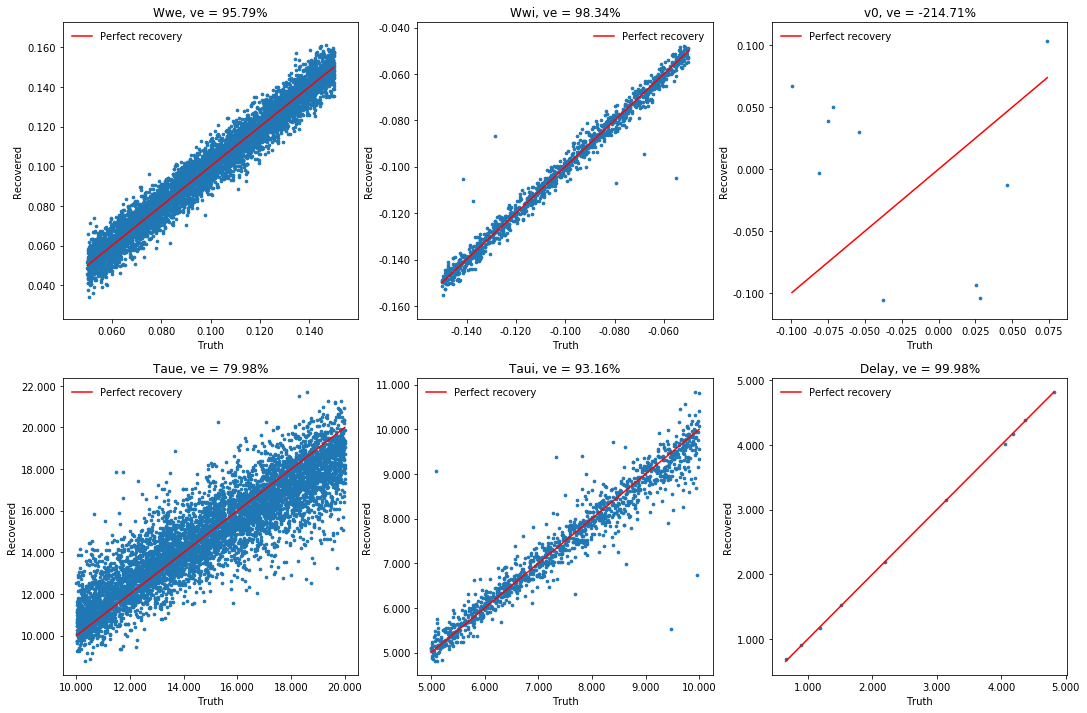

In [7]:
box_accuracies(accuracies=[train_accs, test_accs], labels=['Train', 'Test'])
plot_params_1li(trained_plist, target_plist)

In [8]:
loaded_models = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/val_nSDs_1l2.npz', allow_pickle=True)

In [9]:
target_params_list, trained_params_list, inputs = loaded_models['a'], loaded_models['b'], loaded_models['c']

In [459]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [460]:
# reload parameters, create models with them and extract accuracy metrics

train_accs_list_nsds_1l=[]
test_accs_list_nsds_1l=[]

for j in range(len(target_params_list)):
    params_1l = trained_params_list[j][0]
    params_1n = trained_params_list[j][1]
    params_2n = trained_params_list[j][2]
    params_3n = trained_params_list[j][3]
    params_4n = trained_params_list[j][4]

    hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
    for i in range(len(hln_1l.params)):
        hln_1l.params[i].assign(params_1l[i])

    hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
    for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])

    hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
    for i in range(len(hln_2n.params)):
        hln_2n.params[i].assign(params_2n[i])

    hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True,
                                                                             True, True, True, True]))
    for i in range(len(hln_3n.params)):
        hln_3n.params[i].assign(params_3n[i])

    hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                             True, True, True, True, True, True, True,
                                                                             True]))
    for i in range(len(hln_4n.params)):
        hln_4n.params[i].assign(params_4n[i])

    target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

    for i in range(len(target_model.params)):
        target_model.params[i].assign(target_params_list[j][i])
        
        
    # generate target traces 
    train_target = target_model(train_inputs)
    val_target = target_model(val_inputs)
    test_target = target_model(test_inputs)    
        
        
    # evaluate models on test data:
    train_accs, test_accs = [], []
    models=[hln_1l, hln_1n, hln_2n, hln_3n, hln_4n]
    for model in models:
        train_out, test_out = model(train_inputs), model(test_inputs)
        train_acc = 100 * (1-loss(train_out, train_target)/np.var(train_target))
        test_acc = 100 * (1-loss(test_out, test_target)/np.var(test_target))
        train_accs.append([train_acc.numpy()])
        test_accs.append(test_acc.numpy())

    train_accs_list_nsds_1l.append(train_accs)
    test_accs_list_nsds_1l.append(test_accs)

In [92]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list), a_min=0, a_max=None))

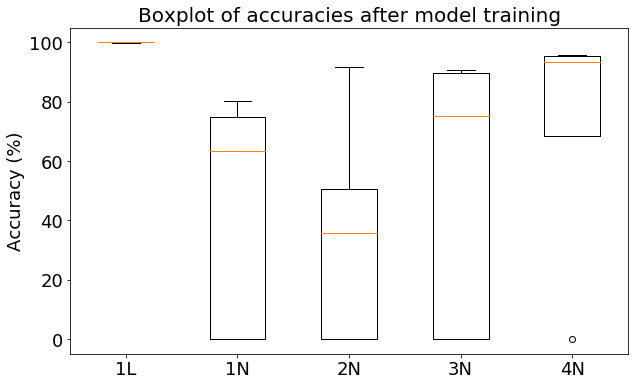

In [130]:
train_accs = np.array(train_accs, ndmin=2)
test_accs = np.array(test_accs, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])


<tf.Tensor: shape=(1,), dtype=bool, numpy=array([False])>

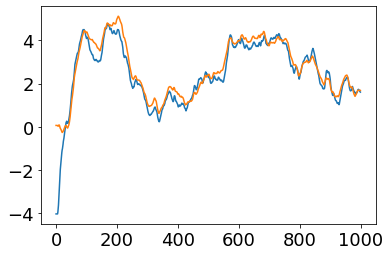

In [104]:
plt.plot(hln_4n(val_inputs).numpy().T[:1000], label='1L attempt')
plt.plot(val_target.numpy().T[:1000], label='Target')
target_model.sig_on

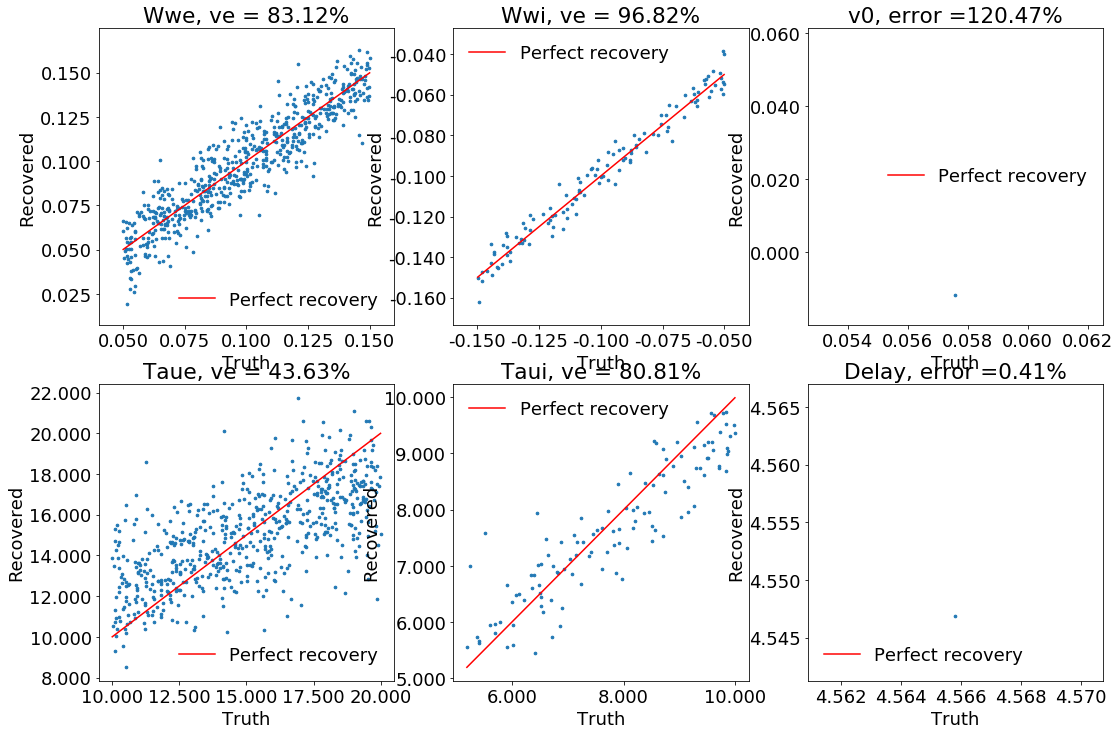

In [117]:
plot_params_1li(trained_params=[params_1l], target_params=[target_params_list[4]])

## Now take trained 1L model and initialise and train each complex model in turn: where are we going wrong?

In [128]:
trained_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])
attempt_1l = trained_1l(train_inputs)
acc_1l= 100*(1-(loss(train_target, attempt_1l)/np.var(train_target)))
print(acc_1l)

tf.Tensor(96.95021, shape=(), dtype=float32)


In [125]:
# now initialise 1n model and train for certain number of epochs
untrained_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
init_nonlin(X=train_inputs, model=untrained_1n, lin_model=trained_1l, nSD=50)
attempt_1n = untrained_1n(train_inputs)
acc_1n = 100*(1-(loss(train_target, attempt_1n)/np.var(train_target)))
print(acc_1n)

tf.Tensor(95.15826, shape=(), dtype=float32)


In [136]:
train_accs_arr_1l3 = np.squeeze(np.clip(np.array(train_accs_list_1l3), a_min=0, a_max=None))
test_accs_arr_1l3 = np.squeeze(np.clip(np.array(test_accs_list_1l3), a_min=0, a_max=None))

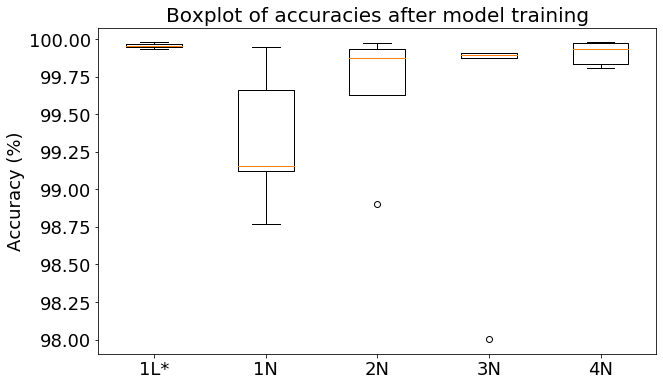

In [184]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_1l3)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

In [143]:
train_accs_arr_3n = np.squeeze(np.clip(np.array(train_accs_list_3n), a_min=0, a_max=None))
test_accs_arr_3n = np.squeeze(np.clip(np.array(test_accs_list_3n), a_min=0, a_max=None))

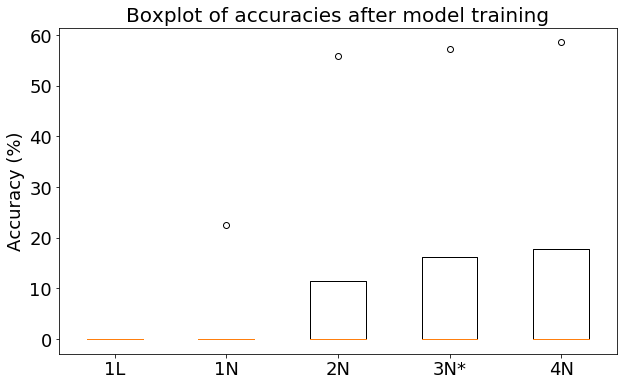

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n)
ax.set_xticklabels(['1L', '1N', '2N', '3N*', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

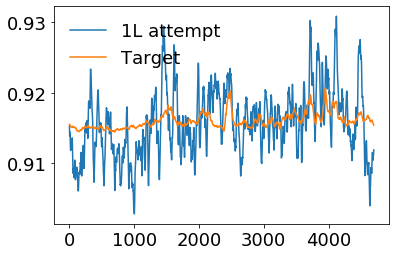

In [163]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()
# target_model.sig_on

In [168]:
train_accs_arr_3n2 = np.squeeze(np.clip(np.array(train_accs_list_3n2), a_min=0, a_max=None))
test_accs_arr_3n2 = np.squeeze(np.clip(np.array(test_accs_list_3n2), a_min=0, a_max=None))

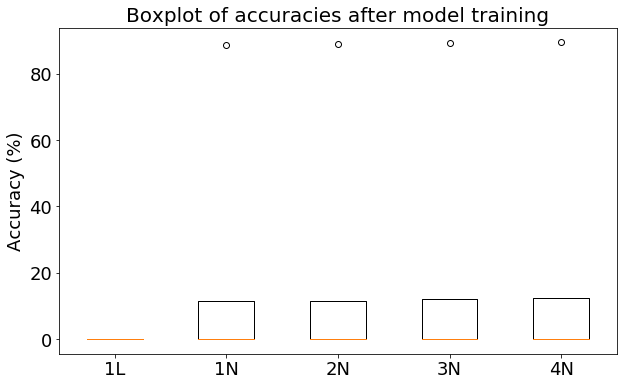

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n2)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

In [173]:
train_accs_arr_3n2

array([[ 0.      , 11.427223, 11.554128, 12.132227, 12.34796 ],
       [ 0.      , 88.679436, 88.99115 , 89.41328 , 89.494385],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],
      dtype=float32)

In [174]:
test_accs_arr_3n2

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , 77.49548, 78.25777, 79.04724, 78.83434],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]], dtype=float32)

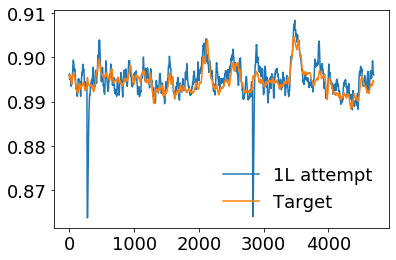

In [182]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()

## Clear problem with Adam optimizer for >1L models and 1L target - training accuracy should not go down when we step up a model. Next run some experiments with Amsgrad variant to try and solve

In [191]:
train_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(train_accs_list_amsgrad_1l), a_min=0, a_max=None))
test_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(test_accs_list_amsgrad_1l), a_min=0, a_max=None))

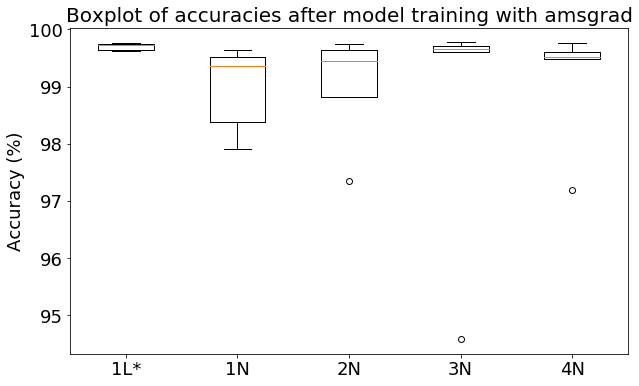

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training with amsgrad', fontsize=20)
ax.boxplot(test_accs_arr_amsgrad_1l)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

In [203]:
train_accs_arr_amsgrad_1l_long = np.squeeze(np.clip(np.array(train_accs_list_amsgrad_1l_long), a_min=0, a_max=None))
test_accs_arr_amsgrad_1l_long = np.squeeze(np.clip(np.array(test_accs_list_amsgrad_1l_long), a_min=0, a_max=None))

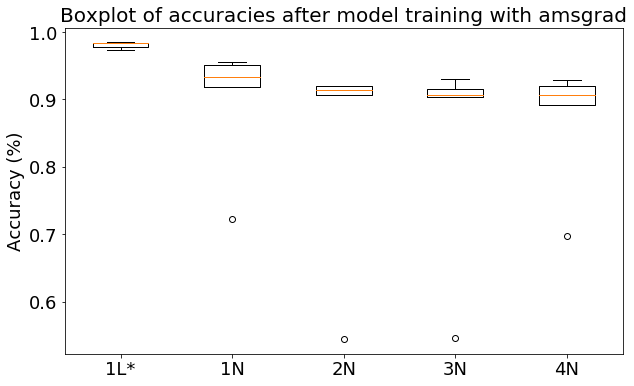

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training with amsgrad', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
ax.boxplot(1-np.sqrt(1-train_accs_arr_amsgrad_1l_long/100))
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

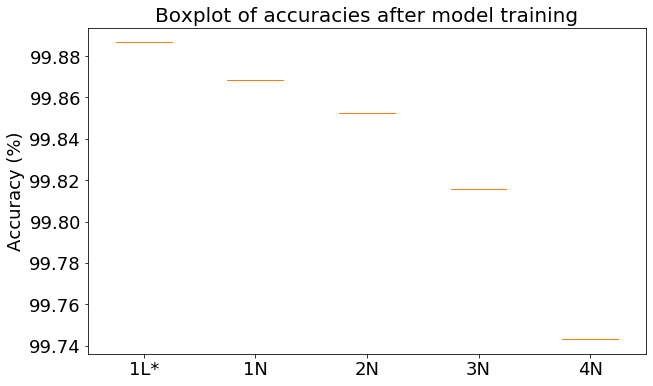

In [469]:
# nsds varied, best result chosen
train_accs = np.squeeze(np.clip(np.array(train_accs_list_nsds_1l), a_min=0, a_max=None))
test_accs = np.squeeze(np.clip(np.array(test_accs_list_nsds_1l), a_min=0, a_max=None))

train_accs = np.array(train_accs, ndmin=2)
test_accs = np.array(test_accs, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(test_accs)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()



# Now look at results from debug_training function - returns accuracy over whole training and validation sets

In [500]:
loaded_debug = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/debug_1l2.npz', allow_pickle=True)

In [501]:
target_params, trained_params, inputs, train_losses, val_losses = loaded_debug['a'], loaded_debug['b'], loaded_debug['c'], loaded_debug['d'], loaded_debug['e']


In [502]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [503]:
train_losses_1l, train_losses_1n, train_losses_2n,train_losses_3n, train_losses_4n = [loss for loss in train_losses]

In [504]:
val_losses_1l, val_losses_1n, val_losses_2n, val_losses_3n, val_losses_4n = [loss for loss in val_losses]

In [505]:
# reproduce target model in order to get accuracies
target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
# target_model=hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))

for i in range(len(target_model.params)):
    target_model.params[i].assign(target_params[i])
    
train_target = target_model(train_inputs)
train_var = np.var(train_target)
val_target = target_model(val_inputs)
val_var = np.var(val_target)

In [506]:
def get_accs(losses, target_variance):
    """function to get accuracy from an array of losses, using the variance of the target trace"""

    accs = 100 * (1 - losses/target_variance)

    return accs

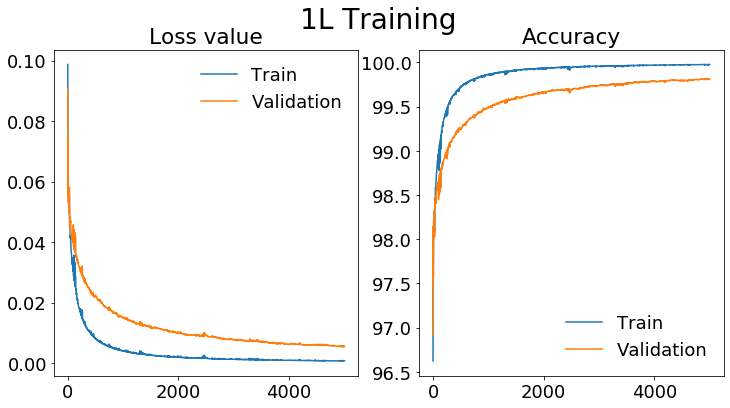

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

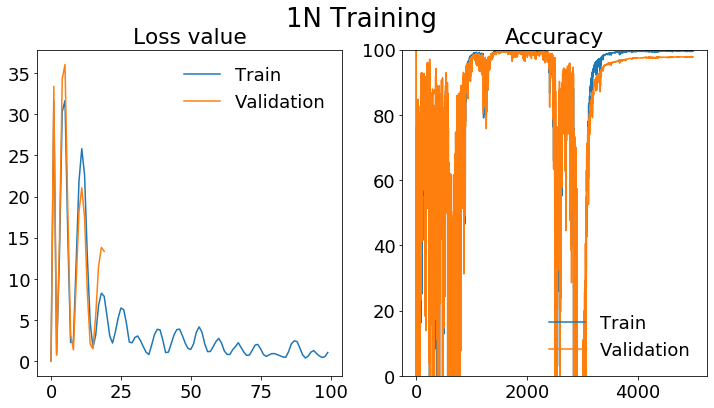

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n[:100], label='Train')
ax[0].plot(val_losses_1n[:20], label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("1N Training", fontsize=26)
plt.show()

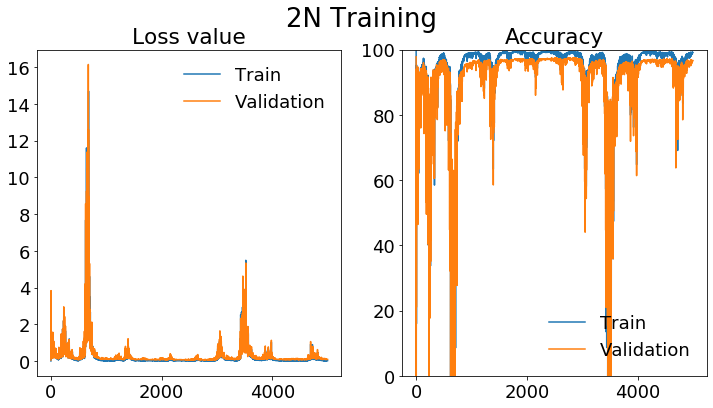

In [244]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

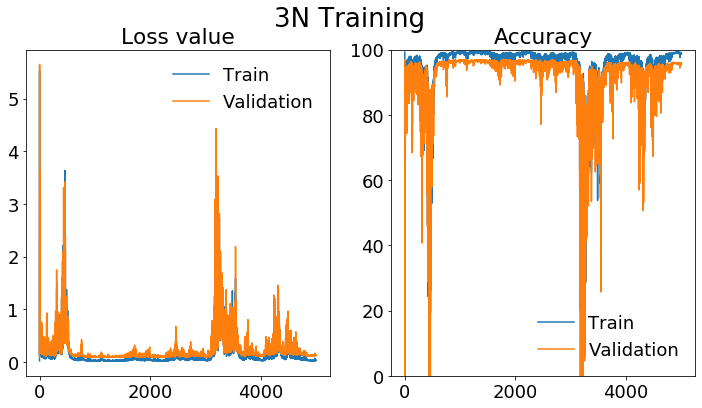

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

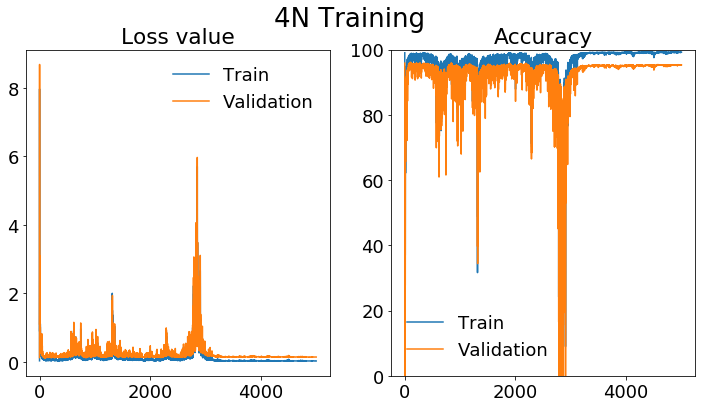

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

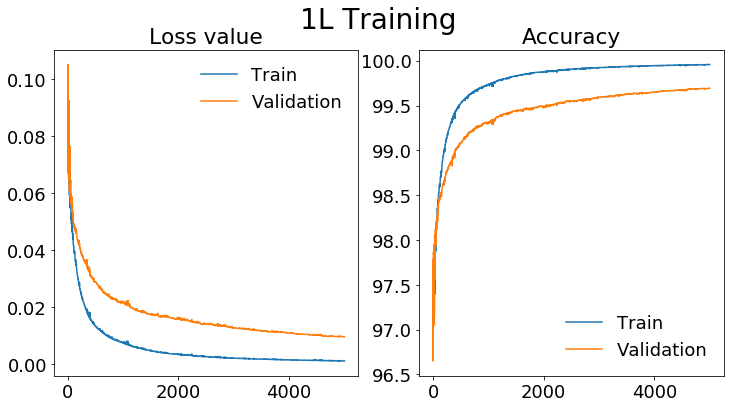

In [507]:
# now lets have a look with smaller nSD=4
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

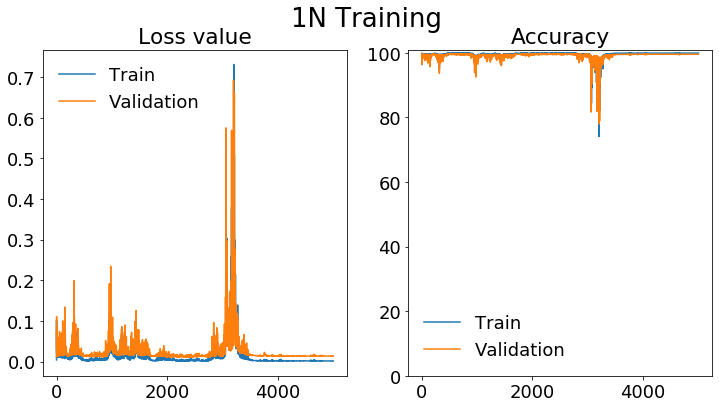

In [508]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,101)

fig.suptitle("1N Training", fontsize=26)
plt.show()

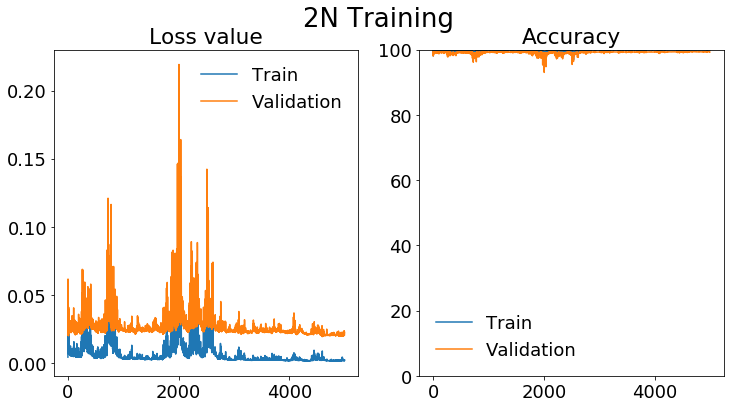

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

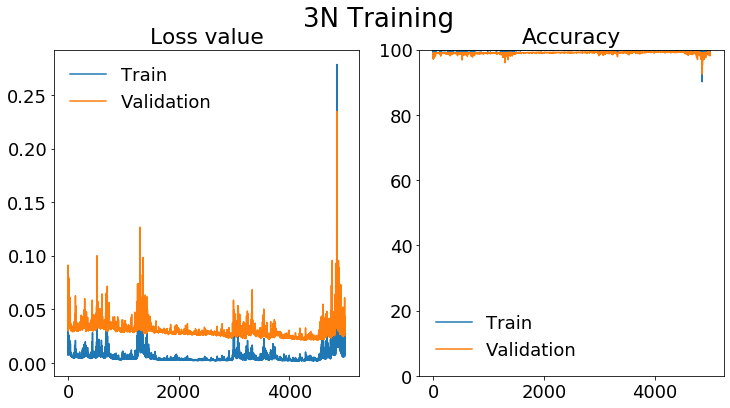

In [279]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

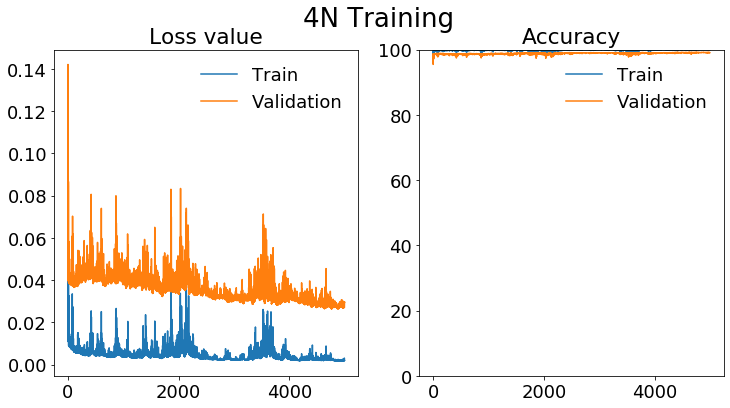

In [280]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

## now lets have a look with smaller nSD yet again, nSD=1

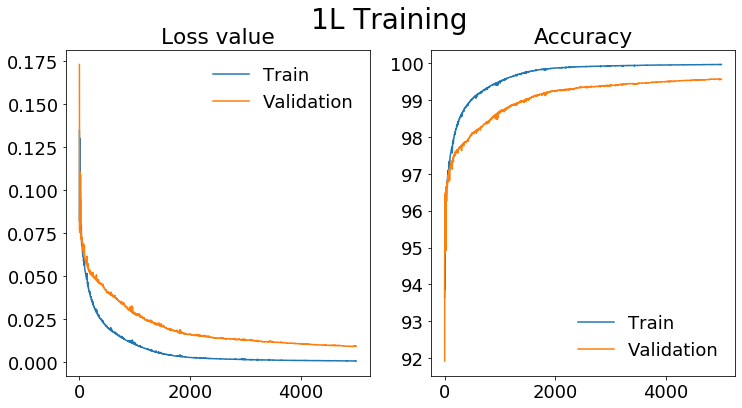

99.96067

In [487]:

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l, label='Train')
ax[0].plot(val_losses_1l, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")

fig.suptitle("1L Training", fontsize=28)
plt.show()

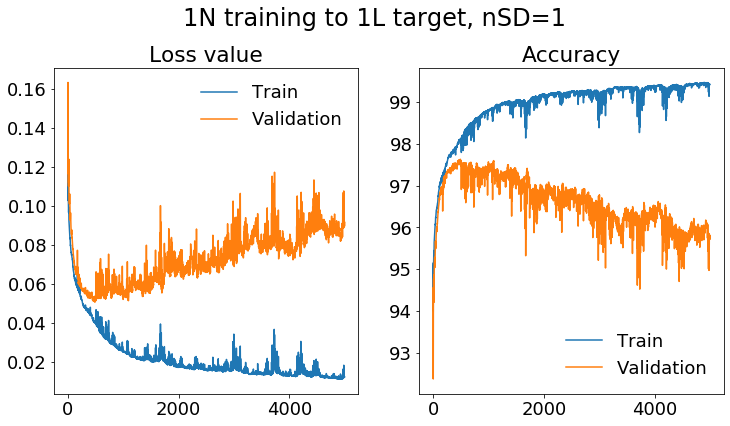

In [499]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,101)

fig.suptitle("1N training to 1L target, nSD=1 ", fontsize=24, y=1.02)
plt.show()

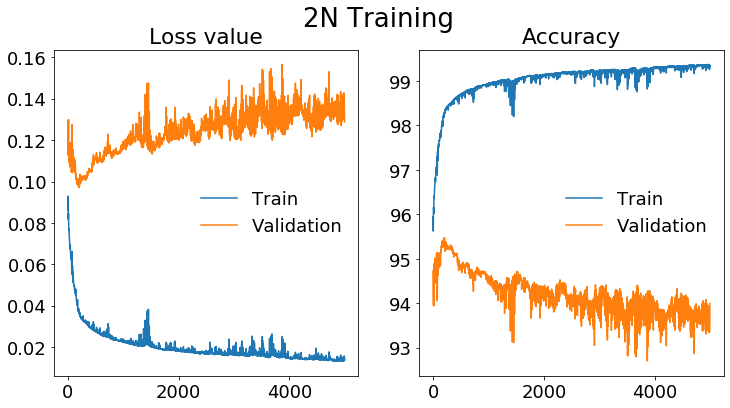

In [454]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

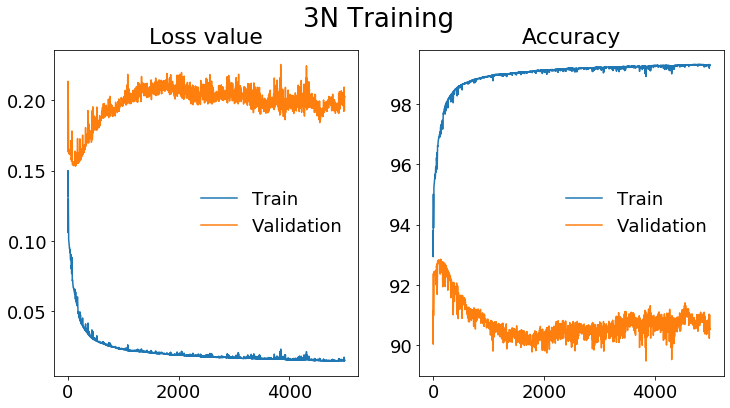

In [455]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

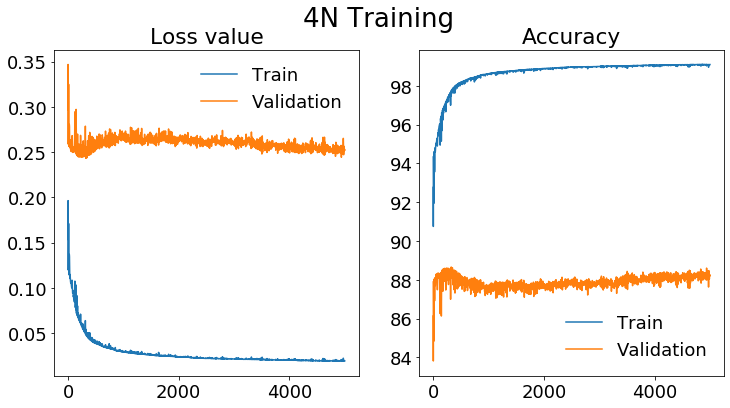

In [456]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

# Also need to find good training procedure for 1L model for complex targets - do we need to tie parameters? Ideally not, experiments here

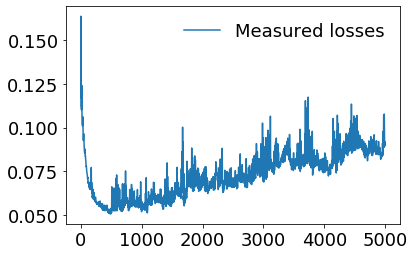

In [373]:
# First we need reliable train_until function - stop training when validation set improvement stagnates, but need to 
# be careful of noisy validation loss due to batch training - try a moving average
val_losses_4n
mas = np.zeros(len(val_losses_1n))
mas[0]=val_losses_1n[0]
alpha=0.99
for i in range(1, len(mas)):
    mas[i] = (alpha * mas[i-1] + (1 - alpha) * val_losses_1n[i])
    
    
plt.plot(val_losses_1n, label="Measured losses")
# plt.plot(mas, label="Moving average")
plt.legend()
plt.show()

### try with 2N target - according to Ujfalussy we should be able to achieve ~75% accuracy with the 1L model

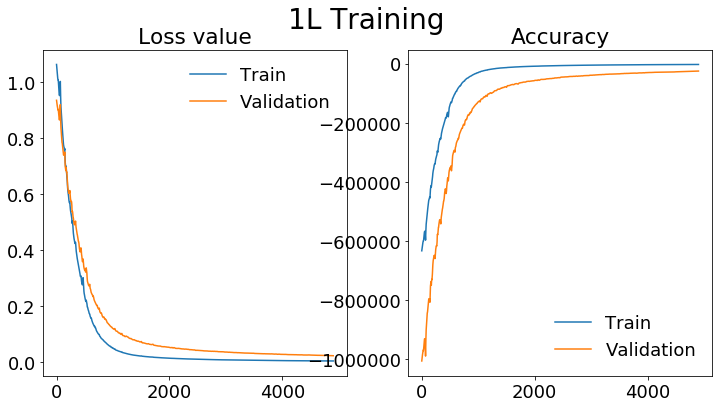

In [317]:
# now lets have a look with smaller nSD yet again, nSD=1
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1l[100:], label='Train')
ax[0].plot(val_losses_1l[100:], label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1l[100:], train_var), label='Train')
ax[1].plot(get_accs(val_losses_1l[100:], val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(bottom=-10000)

fig.suptitle("1L Training", fontsize=28)
plt.show()

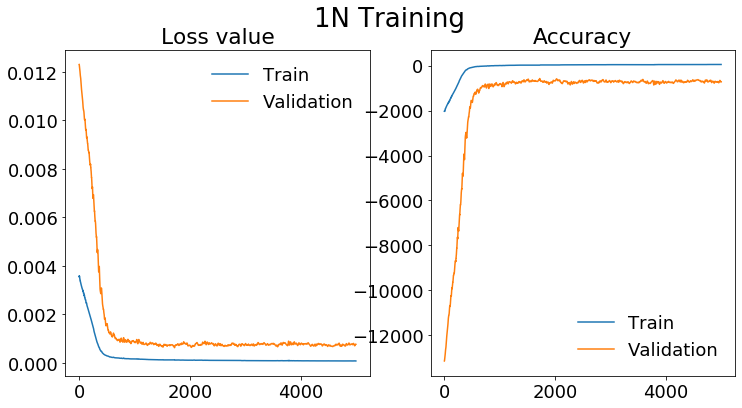

In [308]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_1n, label='Train')
ax[0].plot(val_losses_1n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_1n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_1n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,101)

fig.suptitle("1N Training", fontsize=26)
plt.show()

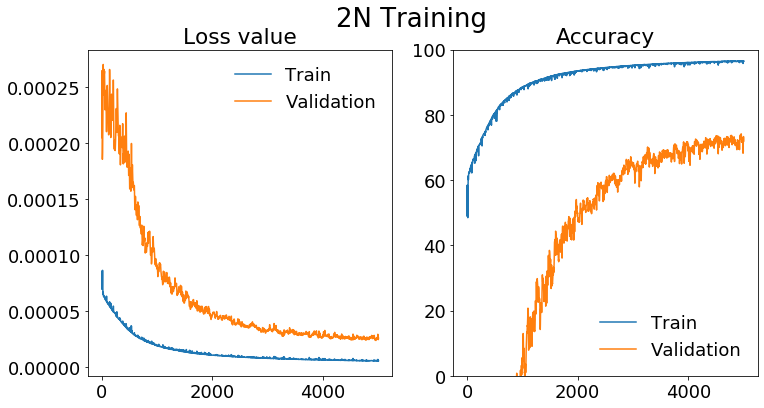

In [309]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_2n, label='Train')
ax[0].plot(val_losses_2n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_2n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_2n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("2N Training", fontsize=26)
plt.show()

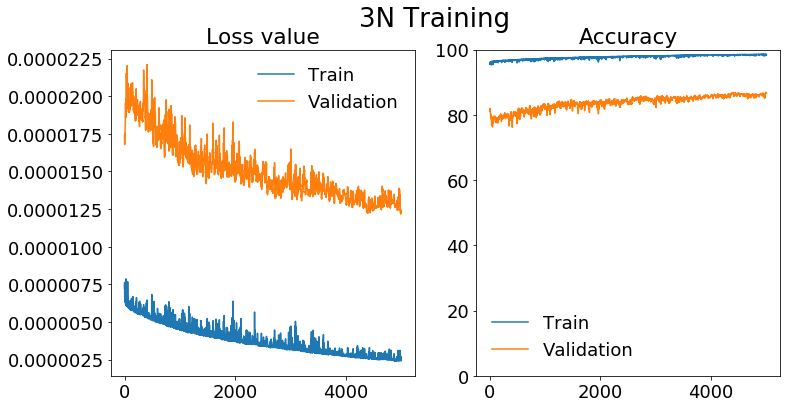

In [310]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_3n, label='Train')
ax[0].plot(val_losses_3n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_3n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_3n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("3N Training", fontsize=26)
plt.show()

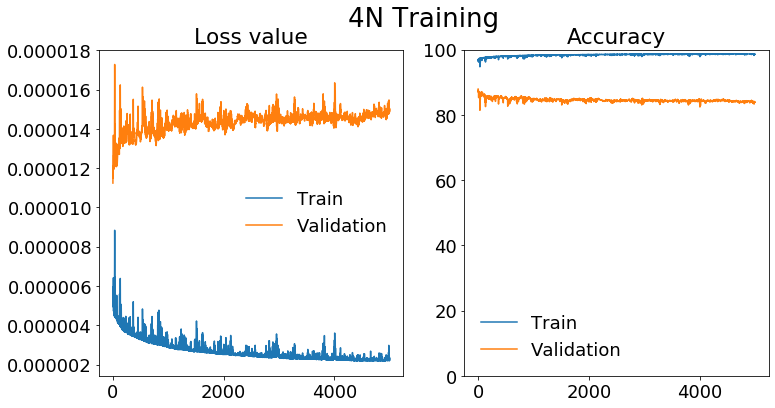

In [311]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(train_losses_4n, label='Train')
ax[0].plot(val_losses_4n, label='Validation')
ax[0].legend()
ax[0].set_title("Loss value")

ax[1].plot(get_accs(train_losses_4n, train_var), label='Train')
ax[1].plot(get_accs(val_losses_4n, val_var), label='Validation')
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_ylim(0,100)

fig.suptitle("4N Training", fontsize=26)
plt.show()

In [419]:
tied = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                                              epsilon=1e-07, amsgrad=True)
ls, accs = train_sgd(tied, 5, optimizer_adam, train_inputs, train_target_2n)

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


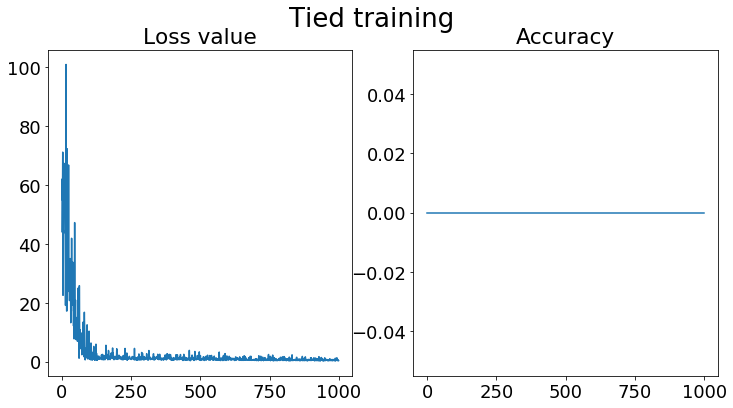

In [410]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 6)
ax[0].plot(ls)
ax[0].set_title("Loss value")

ax[1].plot(accs)
ax[1].set_title("Accuracy")
# ax[1].set_ylim(0,100)

fig.suptitle("Tied training", fontsize=26)
plt.show()

In [408]:
target_model_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
train_target_2n=target_model_2n(train_inputs)

## Compare tied function finished - results below

In [33]:
compare_tied_results = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/comp_tied_2n2.npz', allow_pickle=True)

In [34]:
tied_train_accuracies, tied_test_accuracies, untied_train_accuracies, untied_test_accuracies = compare_tied_results['a'], compare_tied_results['b'], compare_tied_results['c'], compare_tied_results['d']

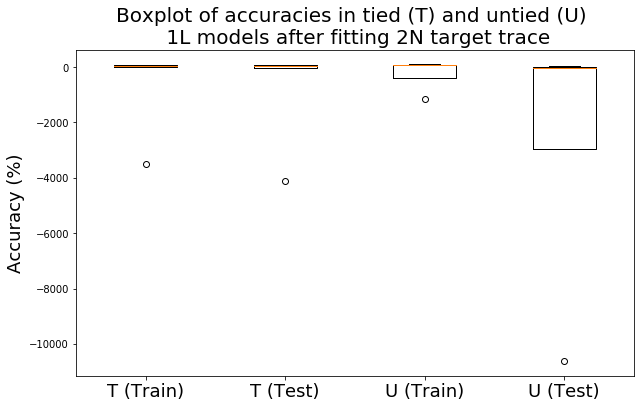

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies in tied (T) and untied (U) \n 1L models after fitting 2N target trace', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
# ax.boxplot([tied_train_accuracies, tied_test_accuracies, untied_train_accuracies, untied_test_accuracies])
ax.boxplot([clip(tied_train_accuracies), clip(tied_test_accuracies), clip(untied_train_accuracies), clip(untied_test_accuracies)])
ax.set_xticklabels(['T (Train)', 'T (Test)', 'U (Train)', 'U (Test)'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(-3000, 100)

plt.show()

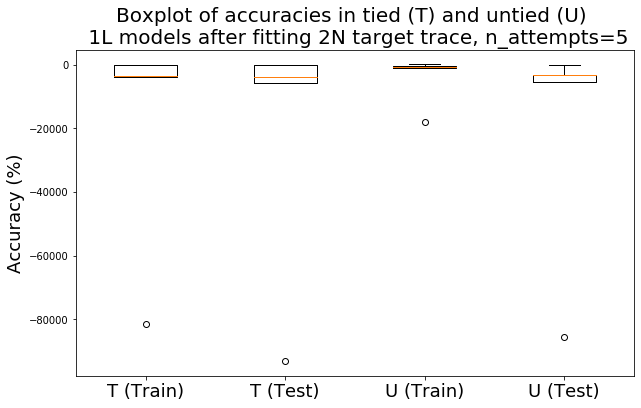

In [37]:
clip = lambda a : np.clip(a, a_min=None, a_max=1000)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies in tied (T) and untied (U) \n 1L models after fitting 2N target trace, n_attempts=5', fontsize=20)
# ax.boxplot(train_accs_arr_amsgrad_1l_long)
ax.boxplot([clip(tied_train_accuracies), clip(tied_test_accuracies), clip(untied_train_accuracies), clip(untied_test_accuracies)])
ax.set_xticklabels(['T (Train)', 'T (Test)', 'U (Train)', 'U (Test)'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(0, 100)

plt.show()

## Wrote new initialisation procedure for tied models - test here

In [37]:
class hLN_TiedModel(object):

    # hLN model with tied parameters - easier than adjusting current model to account for it. Probably want 2 options:
    # tie all synapses to have the same parameters, or one set of parameters for each subunit
    def __init__(self, Jc, Wce, Wci, sig_on):
        # Initialize the parameters in some way
        M = len(Jc)
        self.n_e = np.concatenate(Wce).ravel().shape[0]
        self.n_i = np.concatenate(Wci).ravel().shape[0]
        self.Jc, self.Wce, self.Wci, self.sig_on = Jc, Wce, Wci, sig_on
        self.Jw = tf.random.uniform(shape=[M], minval=1, maxval=1, dtype=tf.float32)
        self.logJw = tf.Variable(tf.math.log(self.Jw))
        self.Wwe = tf.Variable(tf.random.uniform(shape=[M], minval=0.05, maxval=0.15, dtype=tf.float32))
        self.Wwi = tf.Variable(tf.random.uniform(shape=[M], minval=-0.15, maxval=-0.05, dtype=tf.float32))
        self.Taue = tf.random.uniform(shape=[M], minval=10, maxval=20, dtype=tf.float32)
        self.logTaue = tf.Variable(tf.math.log(self.Taue))
        self.Taui = tf.random.uniform(shape=[M], minval=5, maxval=10, dtype=tf.float32)
        self.logTaui = tf.Variable(tf.math.log(self.Taui))
        # can initialise Th to anything as model is initially linear, and then Th will be initialised by another
        # routine when it becomes nonlinear
        self.Th = tf.Variable(tf.random.uniform(shape=[M], minval=-3, maxval=3, dtype=tf.float32))
        self.Delay = tf.random.uniform(shape=[M], minval=0.1, maxval=5, dtype=tf.float32)
        self.logDelay = tf.Variable(tf.math.log(self.Delay))
        self.v0 = tf.Variable(tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.float32))
        self.trainable_params = (self.v0, self.logJw, self.Wwe, self.Wwi, self.logTaue, self.logTaui,
                                 self.Th, self.logDelay)
        self.params = (self.v0, self.logJw, self.Wwe, self.Wwi, self.logTaue, self.logTaui,
                       self.Th, self.logDelay)

        if M == 1 and not sig_on[0]:
            # if single subunit linear model, take out parameters from trainable_params list
            self.logJw.assign([0])
            self.trainable_params = (self.v0, self.Wwe, self.Wwi, self.logTaue, self.logTaui, self.logDelay)

    def __call__(self, x):

        # feedforward model function - before carrying out, create vectors from the single weight and time
        # constant values and assing to parameters
        
        # will concatenate vectors together to form parameter vectors from the tied synaptic weights and time 
        # constants, so intialise empty first
        logTaues = []
        logTauis = []
        Wwes = []
        Wwis = []
        for m in range(len(self.Jc)):
            logTaues = tf.concat((logTaues, tf.fill(dims=[len(self.Wce[m])], value=self.logTaue[m])), axis=0)
            logTauis = tf.concat((logTaues, tf.fill(dims=[len(self.Wci[m])], value=self.logTaui[m])), axis=0)
            Wwes = tf.concat((Wwes, tf.fill(dims=[len(self.Wce[m])], value=self.Wwe[m])), axis=0)
            Wwis = tf.concat((Wwis, tf.fill(dims=[len(self.Wci[m])], value=self.Wwi[m])), axis=0)
        
#         logTaues = tf.fill(dims=[self.n_e], value=self.logTaue)
#         logTauis = tf.fill(dims=[self.n_i], value=self.logTaui)
#         Wwes = tf.fill(dims=[self.n_e], value=self.Wwe)
#         Wwis = tf.fill(dims=[self.n_i], value=self.Wwi)
        self.params = (self.v0, self.logJw, Wwes, Wwis, logTaues, logTauis,
                       self.Th, self.logDelay)
        
        # now option with different parameters on each subunit 

        return sim_hLN_tf2(X=x, dt=1, Jc=self.Jc, Wce=self.Wce, Wci=self.Wci, params=self.params, sig_on=self.sig_on)

    def randomise_parameters(self):
        M = len(self.Jc)
        self.Jw = tf.random.uniform(shape=[M], minval=1, maxval=1, dtype=tf.float32)
        self.logJw.assign(tf.math.log(self.Jw))
        self.Wwe.assign(tf.random.uniform(shape=(), minval=0.05, maxval=0.15, dtype=tf.float32))
        self.Wwi.assign(tf.random.uniform(shape=(), minval=-0.15, maxval=-0.05, dtype=tf.float32))
        self.Taue = tf.random.uniform(shape=(), minval=10, maxval=20, dtype=tf.float32)
        self.logTaue.assign(tf.math.log(self.Taue))
        self.Taui = tf.random.uniform(shape=(), minval=5, maxval=10, dtype=tf.float32)
        self.logTaui.assign(tf.math.log(self.Taui))
        # can initialise Th to anything as model is initially linear, and then Th will be initialised by another
        # routine when it becomes nonlinear
        self.Th.assign(tf.random.uniform(shape=[M], minval=-3, maxval=3, dtype=tf.float32))
        self.Delay = tf.random.uniform(shape=[M], minval=0.1, maxval=5, dtype=tf.float32)
        self.logDelay.assign(tf.math.log(self.Delay))
        self.v0.assign(tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.float32))
        self.trainable_params = (self.v0, self.logJw, self.Wwe, self.Wwi, self.logTaue, self.logTaui,
                                 self.Th, self.logDelay)
        self.params = (self.v0, self.logJw, self.Wwe, self.Wwi, self.logTaue, self.logTaui,
                       self.Th, self.logDelay)

        if M == 1 and not self.sig_on[0]:
            # if single subunit linear model, take out parameters from trainable_params list
            self.logJw.assign([0])
            self.trainable_params = (self.v0, self.Wwe, self.Wwi, self.logTaue, self.logTaui, self.logDelay)

        return


In [48]:
def init_nonlin_tied(X, model, lin_model, nSD, dt=1):
    """function to initialise the nonlinearities in subunits which were previously nonlinear. The parameters
     of the linear model should already have been optimised, and as such its accuracy should be a lower bound on the
    accuracy of the new non-linear model. This function is for models of type hLN_TiedModel only, as parameter
    definitions differ slightly from the untied version
    X: binary matrix of inputs
    model: nonlinear model to set parameters for
    lin_model: linear model with same architecture, parameters of which have been optimised
    """

    # first set parameters of new nonlinear model to those of optimised linear model
    model.logJw.assign(lin_model.logJw)
    model.Wwe.assign(lin_model.Wwe)
    model.Wwi.assign(lin_model.Wwi)
    model.logTaue.assign(lin_model.logTaue)
    model.logTaui.assign(lin_model.logTaui)
    model.Th.assign(lin_model.Th)
    model.logDelay.assign(lin_model.logDelay)
    model.v0.assign(lin_model.v0)
    # model.params = (model.v0, model.log_Jw, model.Wwe, model.Wwi, model.log_Tau_e, model.log_Tau_i,
    #                model.Th, model.log_Delay)
    # model.trainable_params = (model.v0, model.log_Jw, model.Wwe, model.Wwi, model.log_Tau_e, model.log_Tau_i,
    #                          model.Th, model.log_Delay)



    # to extend to more subunits, make everything numpy so we can assign it. Then convert back to tensors at the end
    Jc, Wce, Wci = model.Jc, model.Wce, model.Wci
    # params should be parameters of a previously created hLN model - convert to numpy so we can assign
    v0, log_Jw, Wwe, Wwi, log_Tau_e, log_Tau_i, Th, log_Delay = [param.numpy() for param in model.params]



    # these parameters defined by their logs to ensure positivity - convert here
    Jw, Tau_e, Tau_i, Delay = np.exp(log_Jw), np.exp(log_Tau_e), np.exp(log_Tau_i), np.exp(log_Delay)

    N = X.shape[0]
    L = X.shape[1]
    Tmax = L / dt
    M = len(Jc)
    if M == 1: #single subunit model - adjust parameters such that Jw is 1 initially
        Wwe *= Jw[0]
        Wwi *= Jw[0]
        Jw /= Jw

    # first find which subunits we want to initialise nonlinearities for - should just be the leaves:
    leaves = np.setdiff1d(np.arange(1, M + 1, 1), Jc)

    # now calculate synaptic input to each dendritic branch - will use this to scale
    # need to assign rescaled parameters first
    model.Wwe.assign(Wwe)
    model.Wwi.assign(Wwi)
    model.logJw.assign(np.log(Jw))

#     logTaues = tf.fill(dims=[model.n_e], value=model.logTaue)
#     logTauis = tf.fill(dims=[model.n_i], value=model.logTaui)
#     Wwes = tf.fill(dims=[model.n_e], value=model.Wwe)
#     Wwis = tf.fill(dims=[model.n_i], value=model.Wwi)
    
    
    logTaues = []
    logTauis = []
    Wwes = []
    Wwis = []
    for m in range(len(model.Jc)):
        logTaues = tf.concat((logTaues, tf.fill(dims=[len(model.Wce[m])], value=model.logTaue[m])), axis=0)
        logTauis = tf.concat((logTaues, tf.fill(dims=[len(model.Wci[m])], value=model.logTaui[m])), axis=0)
        Wwes = tf.concat((Wwes, tf.fill(dims=[len(model.Wce[m])], value=model.Wwe[m])), axis=0)
        Wwis = tf.concat((Wwis, tf.fill(dims=[len(model.Wci[m])], value=model.Wwi[m])), axis=0)

    
    
    model.params = (model.v0, model.logJw, Wwes, Wwis, logTaues, logTauis,
                    model.Th, model.logDelay)
    Y = sim_inputs(X=X, dt=1, Jc=model.Jc, Wce=model.Wce, Wci=model.Wci, params=model.params, sig_on=model.sig_on)
    Y = Y.numpy()
    
    # now we have synaptic input, convert Wwes and Wwis back into numpy for easier processing
    Wwes, Wwis = Wwes.numpy(), Wwis.numpy()

    #  we only need to initialise nonlinearities in the leaves:
    for leaf in leaves:

        range_Y = np.std(Y[leaf - 1, :])
        alpha = (nSD * range_Y)
        # print(alpha)
        if len(Wce[leaf-1] > 0):  # if leaf has any e neurons connected to it
            Wwes[(Wce[leaf-1])] /= alpha
            Wwe[leaf-1] /= alpha
            
        if len(Wci[leaf-1] > 0):  # if leaf has any i neurons connected to it
            Wwis[(Wci[leaf-1] - model.n_e)] /= alpha
            Wwi[leaf - 1]/= alpha

        Th[leaf-1] = np.mean(Y[leaf - 1, :]) / alpha

        Jw[leaf-1] *= (4 * alpha)

        if leaf != 1:  #if not the soma
            parent = Jc[leaf-1]
            Th[parent-1] -= (np.mean(Y[leaf - 1, :]) - 2 * alpha)

        else:  # soma: add offset into v0
            v0 += (np.mean(Y[leaf - 1, :]) - 2 * alpha)


    logJw, logTaue, logTaui, logDelay = np.log(Jw), np.log(Tau_e), np.log(Tau_i), np.log(Delay)

    model.logJw.assign(logJw)
    model.Wwe.assign(Wwe)
    model.Wwi.assign(Wwi)
    model.Th.assign(Th)
    model.logDelay.assign(logDelay)
    model.v0.assign(v0)

    return

In [51]:
def update_arch_tied(prev_model, next_model):
    """Function to assign the correct parameters to a new architecture which has added new linear leaf subunits
    from the previous architecture. The Jc, Wce and Wci of the new architecture are known, so the synaptic
    parameters just need to be redistributed accordingly. This new function is required for the tied models,
    as the parameters are defined differently and so need to be redistributed differently also."""

    # first change hLN attributes into numpy - allows assignment and should be easier to manipulate
    logJw = next_model.logJw.numpy()
    logDelay = next_model.logDelay.numpy()
    Th = next_model.Th.numpy()
    Wwe, Wwi = next_model.Wwe.numpy(), next_model.Wwi.numpy()
    logTaue, logTaui = next_model.logTaue.numpy(), next_model.logTaui.numpy()

    # then initialise 'substructure' of new model to be identical to previous model (i.e. subsection of new
    # architecture that made up the previous model)
    M_old = len(prev_model.Jc)
    logJw[:M_old] = prev_model.logJw.numpy()
    logDelay[:M_old] = prev_model.logDelay.numpy()
    Th[:M_old] = prev_model.Th.numpy()
    Wwe[:M_old], Wwi[:M_old] = prev_model.Wwe.numpy(), prev_model.Wwi.numpy()
    logTaue[:M_old], logTaui[:M_old] = prev_model.logTaue.numpy(), prev_model.logTaui.numpy()


    # work out which subunits we have just added - for these cases should just be the leaves
    M = len(next_model.Jc)
    leaves = np.setdiff1d(np.arange(1, M + 1, 1), next_model.Jc)
    for leaf in leaves:
        logJw[leaf - 1] = 0  # set subunit gain to 1 for all new leaves
        # then set delay to the delay of the subunit parent from the previous model
        parent = next_model.Jc[leaf - 1]
        logDelay[leaf - 1] = prev_model.logDelay.numpy()[parent - 1]
        # also set weights and time constants to those of subunit parent in previous model
        Wwe[leaf-1] = prev_model.Wwe.numpy()[parent - 1]
        Wwi[leaf-1] = prev_model.Wwi.numpy()[parent - 1]
        logTaue[leaf-1] = prev_model.logTaue.numpy()[parent - 1]
        logTaui[leaf-1] = prev_model.logTaui.numpy()[parent - 1]
        


    # assign the newly calculated parameters to the new model
    next_model.Wwe.assign(Wwe)
    next_model.Wwi.assign(Wwi)
    next_model.logTaue.assign(logTaue)
    next_model.logTaui.assign(logTaui)
    next_model.logJw.assign(logJw)
    next_model.logDelay.assign(logDelay)
    next_model.Th.assign(Th)
    next_model.v0.assign(prev_model.v0)

    return

In [52]:
hln_1l = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

target=hln_1l(inputs)

hln_1n = hLN_TiedModel(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
init_nonlin_tied(X=inputs, model=hln_1n, lin_model=hln_1l, nSD=40)
attempt_1n = hln_1n(inputs)
acc_1n = 100*(1-(loss(target, attempt_1n)/np.var(target)))
print(acc_1n)

hln_2l = hLN_TiedModel(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, False, False]))
update_arch_tied(prev_model=hln_1n, next_model=hln_2l)
attempt_2l = hln_2l(inputs)
acc_2l = 100*(1-(loss(target, attempt_2l)/np.var(target)))
print(acc_2l)

hln_2n = hLN_TiedModel(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
init_nonlin_tied(X=inputs, model=hln_2n, lin_model=hln_2l, nSD=40)
attempt_2n = hln_2n(inputs)
acc_2n = 100*(1-(loss(target, attempt_2n)/np.var(target)))
print(acc_2n)

hln_3l = hLN_TiedModel(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, False, False, False, False]))
update_arch_tied(prev_model=hln_2n, next_model=hln_3l)
attempt_3l = hln_3l(inputs)
acc_3l = 100*(1-(loss(target, attempt_3l)/np.var(target)))
print(acc_3l)

hln_3n = hLN_TiedModel(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, True, True, True, True]))
init_nonlin_tied(X=inputs, model=hln_3n, lin_model=hln_3l, nSD=40)
attempt_3n = hln_3n(inputs)
acc_3n = 100*(1-(loss(target, attempt_3n)/np.var(target)))
print(acc_3n)

hln_4l = hLN_TiedModel(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True, 
                                                         False, False, False, False, False, False, False, False]))
update_arch_tied(prev_model=hln_3n, next_model=hln_4l)
attempt_4l = hln_4l(inputs)
acc_4l = 100*(1-(loss(target, attempt_4l)/np.var(target)))
print(acc_4l)

hln_4n = hLN_TiedModel(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                     True, True, True, True, True, True, True, True]))
init_nonlin_tied(X=inputs, model=hln_4n, lin_model=hln_4l, nSD=40)
attempt_4n = hln_4n(inputs)
acc_4n = 100*(1-(loss(target, attempt_4n)/np.var(target)))
print(acc_4n)

tf.Tensor(99.99999, shape=(), dtype=float32)
tf.Tensor(99.99999, shape=(), dtype=float32)
tf.Tensor(99.99996, shape=(), dtype=float32)
tf.Tensor(99.99996, shape=(), dtype=float32)
tf.Tensor(99.99991, shape=(), dtype=float32)
tf.Tensor(99.99991, shape=(), dtype=float32)
tf.Tensor(99.99976, shape=(), dtype=float32)


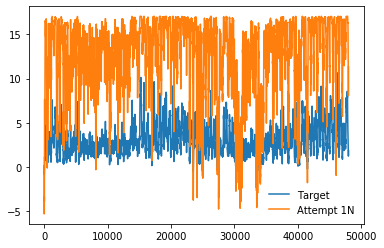

In [11]:
plt.plot(target.numpy().T, label='Target')
# Y = sim_inputs(X=inputs, dt=1, Jc=hln_1l.Jc, Wce=hln_1l.Wce, Wci=hln_1l.Wci, params=hln_1l.params, sig_on=hln_1l.sig_on)
plt.plot(attempt_1n.numpy().T, label='Attempt 1N')
# plt.plot(Y.numpy().T, label='sim_inputs')
plt.legend()

In [38]:
hln_3n = hLN_TiedModel(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, True, True, True, True]))
logTaues = []
for m in range(len(hln_3n.Jc)):
#     if len(hln_3n.Wce[m])>0:
    logTaues = tf.concat((logTaues, tf.fill(dims=[len(hln_3n.Wce[m])], value=hln_3n.logTaue[m])), axis=0)

In [39]:
hln_3n(inputs)

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([0.40777475, 0.40777475, 0.40777475, ..., 0.28101975, 0.28101197,
       0.28102306], dtype=float32)>

In [25]:
b

<tf.Tensor: shape=(1258,), dtype=int32, numpy=array([3, 3, 3, ..., 3, 3, 3], dtype=int32)>